In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline
matplotlib.rcParams["figure.dpi"] = 200

In [2]:
time_list = []
for i in range(0, 24):
    for k in range(0, 4):
        time_list.append(i+k*.25)

In [3]:
from predictor.environment import DailyUsageEnv

In [4]:
env = DailyUsageEnv(heating_power=8, water_thres=120)

In [5]:
env.reset()
total_iterations = 100
water_temp = np.zeros((96,))
usage = np.zeros((96,))
reward = np.zeros((96,))
energy_usage = np.zeros((96,))
for k in range(total_iterations):
    for i in range(96):
        spec = env.step(1)
        water_temp[i] += (spec.observation["water_temperature"]) * 1/total_iterations
        usage[i] += (spec.observation["usage_state"]) * 1/total_iterations
        energy_usage[i] += (spec.observation["boiler_state"]) * 1/total_iterations
        reward[i] += (spec.reward) * 1/total_iterations
    env.reset()
    

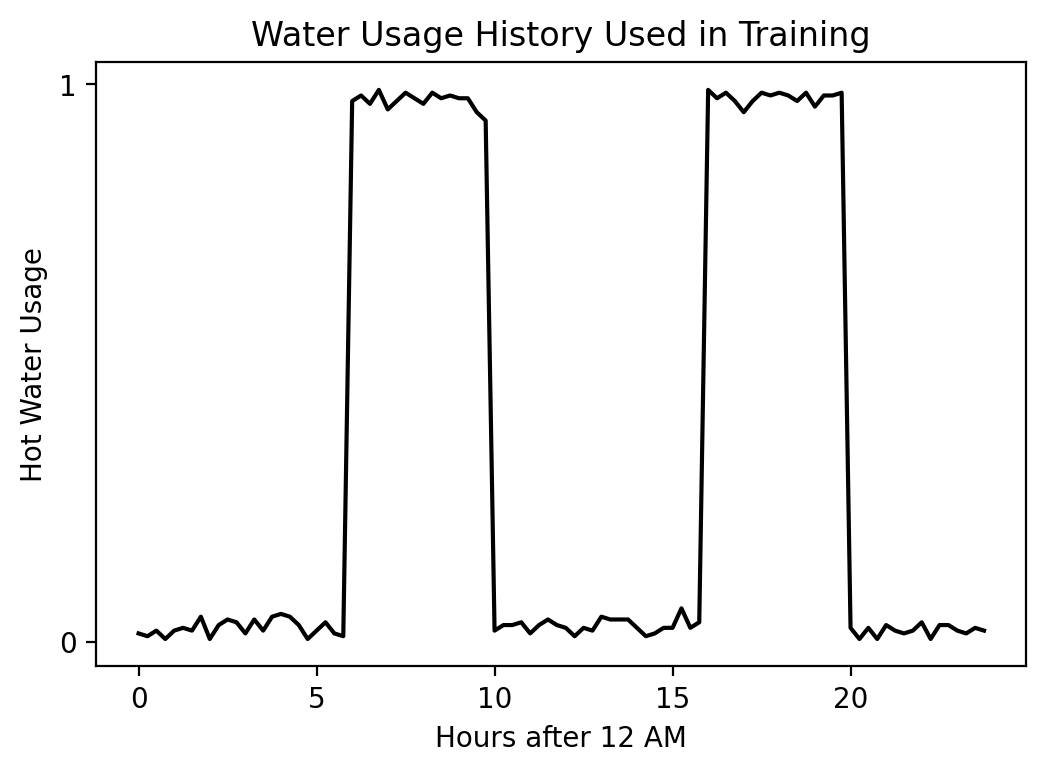

In [6]:
plt.plot(time_list, usage, "black")
plt.xlabel("Hours after 12 AM")
plt.yticks([0, 1])
plt.ylabel("Hot Water Usage")
plt.title("Water Usage History Used in Training")
plt.savefig("usage_train.png")

# Trained Policy

In [7]:
from predictor.predict import *

In [8]:
predict = Predictor(env, policy_dir="./predictor/models/policy_paper_one")

In [9]:
predict.time_step.observation

{'history': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]),
 'boiler_state': array([0]),
 'usage_state': array([0.], dtype=float32),
 'water_temperature': array([72])}

In [10]:
total_iterations = 50
water_temp = np.zeros((total_iterations, 96,))
usage = np.zeros((total_iterations, 96,))
reward = np.zeros((total_iterations, 96,))
energy_usage = np.zeros((total_iterations, 96,))
actions = np.zeros((total_iterations, 96, ))
for k in tqdm(range(total_iterations)):
    env.reset()
    for i in range(96):
        action, spec = predict.predict()
        actions[k][i] = action
        water_temp[k][i] = (spec.observation["water_temperature"])
        usage[k][i] = (spec.observation["usage_state"])
        energy_usage[k][i] = (spec.observation["boiler_state"])
        reward[k][i] = (spec.reward)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


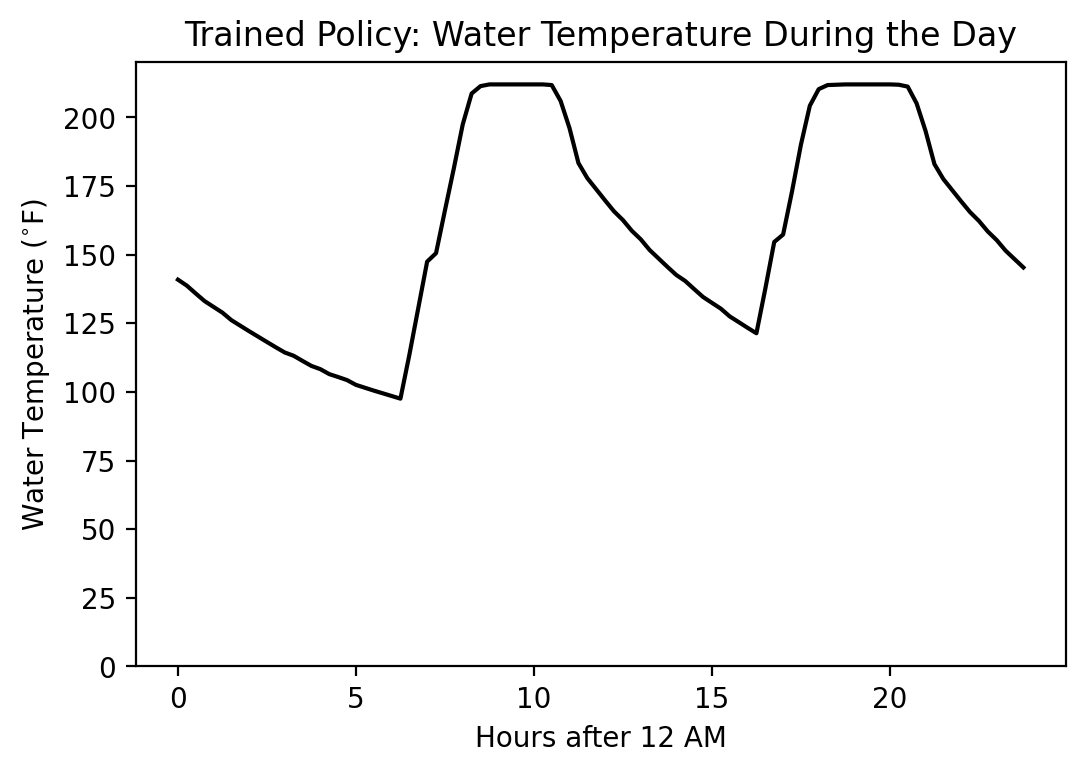

In [11]:
plt.plot(time_list, np.mean(water_temp, axis=0), "black")
plt.xlabel("Hours after 12 AM")
plt.ylabel(r"Water Temperature ($^{\circ}$F)")
plt.title("Trained Policy: Water Temperature During the Day")
plt.ylim([0, 220])
plt.savefig("trained_water_temp.png")

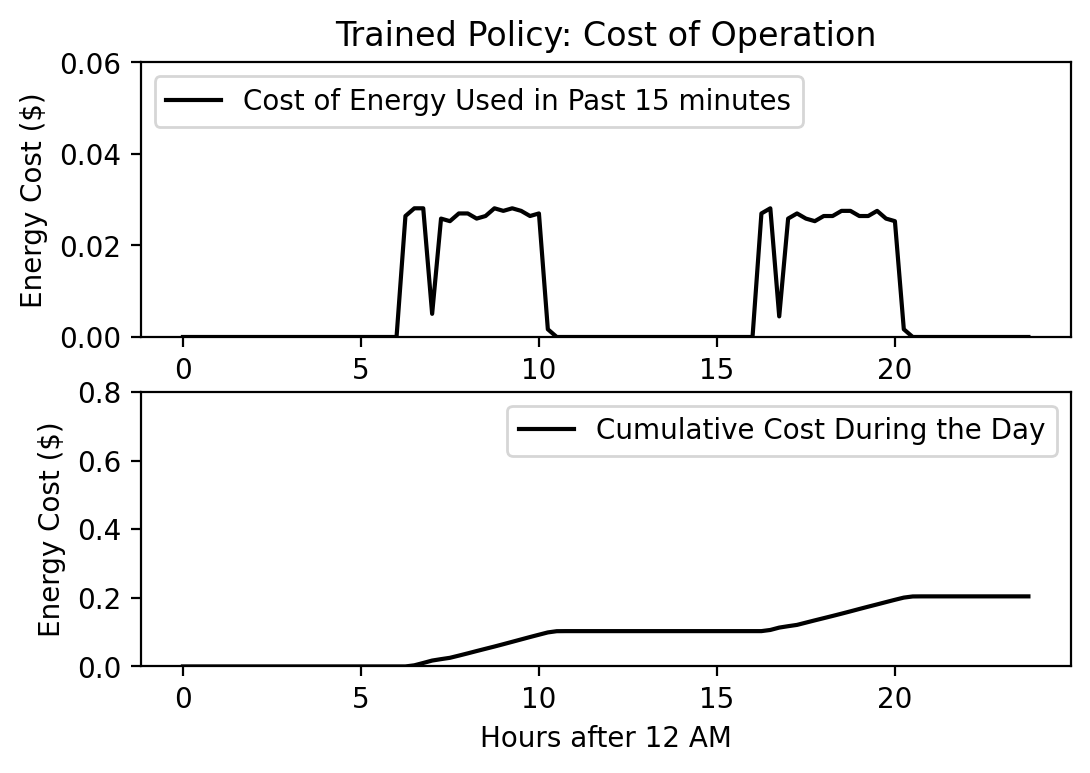

In [12]:
# Cumulative area under curve
cum_auc = [0]
x = time_list
y = np.mean(energy_usage*3*15/60 * 0.0375, axis=0)
for i in range(1, len(x)):
    cum_auc.append(np.trapz(y[0:i], x[0:i]))
plt.figure()
plt.subplot(211)
plt.title("Trained Policy: Cost of Operation")
plt.plot(time_list, np.mean(energy_usage*3*15/60 * 0.0375, axis=0), "black", label="Cost of Energy Used in Past 15 minutes")
plt.ylabel("Energy Cost ($)")
plt.legend(loc="upper left")
plt.ylim([0, 0.06])
plt.subplot(212)
plt.plot(time_list, cum_auc, "black", label="Cumulative Cost During the Day")
plt.legend()
plt.xlabel("Hours after 12 AM")
plt.ylabel("Energy Cost ($)")
plt.ylim([0, .8])
plt.savefig("trained_energy_plot.png")

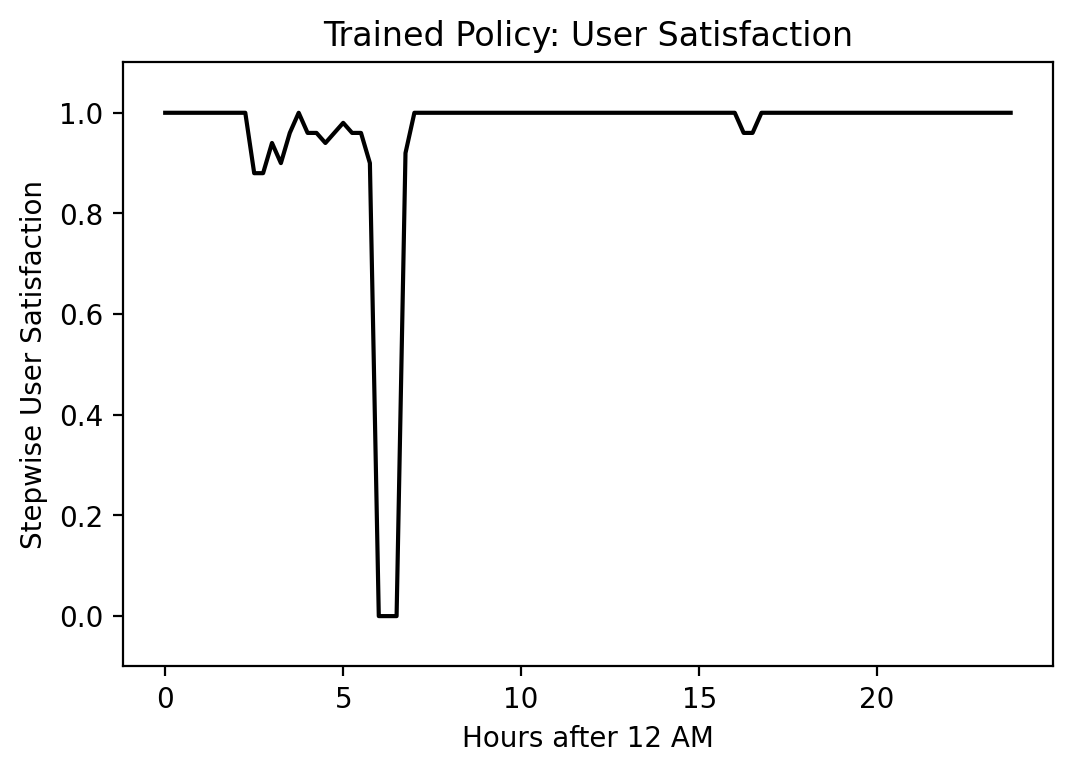

In [13]:
# Cumulative area under curve
cum_auc = [0]
x = time_list
y = np.mean(np.logical_not(reward < -150), axis=0)
for i in range(1, len(x)):
    cum_auc.append(np.trapz(y[0:i], x[0:i]))
plt.ylim([-0.1, 1.1])
plt.title("Trained Policy: User Satisfaction")
plt.plot(time_list, np.mean(np.logical_not(reward < -100), axis=0), "black", label="Stepwise Satisfaction")
plt.xlabel("Hours after 12 AM")
plt.ylabel("Stepwise User Satisfaction")
plt.savefig("trained_day_reward.png")

# Standard Policy

In [14]:
def standard_pred(time_spec):
    if time_spec.observation["water_temperature"] == 212:
        return 2
    else:
        return 1

In [15]:
env.reset()
total_iterations = 50
water_temp = np.zeros((total_iterations, 96,))
usage = np.zeros((total_iterations, 96,))
reward = np.zeros((total_iterations, 96,))
energy_usage = np.zeros((total_iterations, 96,))
actions = np.zeros((total_iterations, 96, ))
for k in tqdm(range(total_iterations)):
    spec = env.reset()
    for i in range(96):
        action = standard_pred(spec)
        actions[k][i] = action
        spec = env.step(action)
        water_temp[k][i] = (spec.observation["water_temperature"])
        usage[k][i] = (spec.observation["usage_state"])
        energy_usage[k][i] = (spec.observation["boiler_state"])
        reward[k][i] = (spec.reward)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.88it/s]


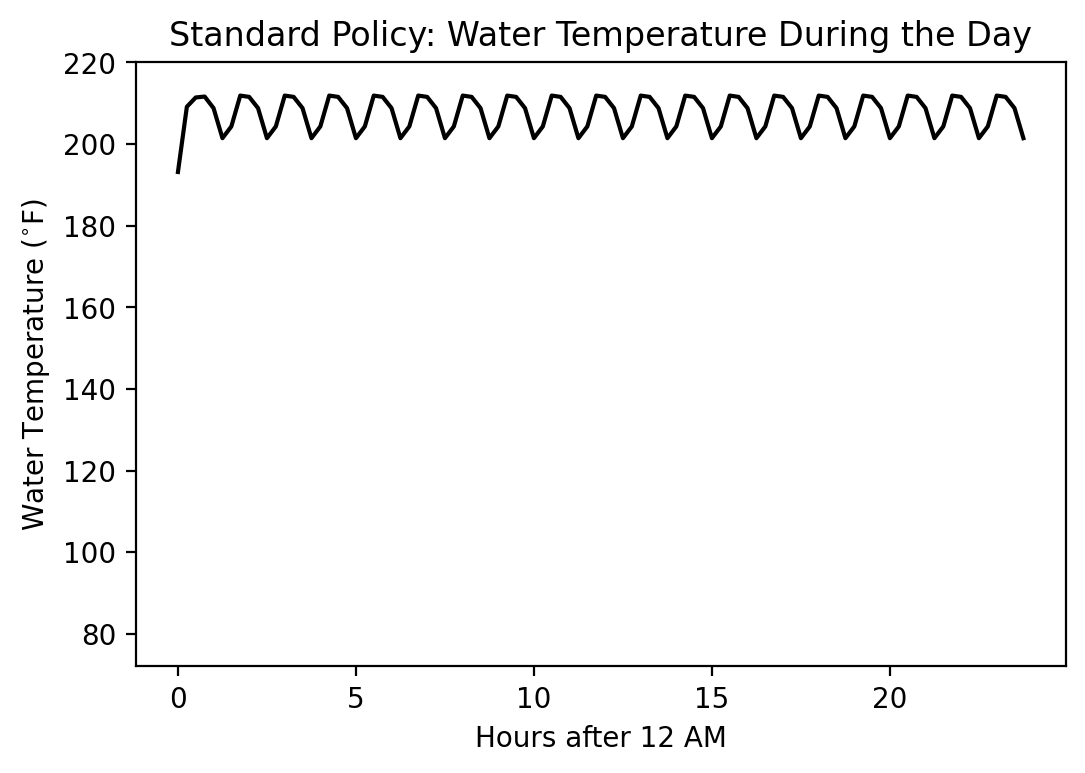

In [16]:
plt.plot(time_list, np.mean(water_temp, axis=0), "black")
plt.xlabel("Hours after 12 AM")
plt.ylabel(r"Water Temperature ($^{\circ}$F)")
plt.ylim([72, 220])
plt.title("Standard Policy: Water Temperature During the Day")
plt.savefig("standard_water_temp.png")

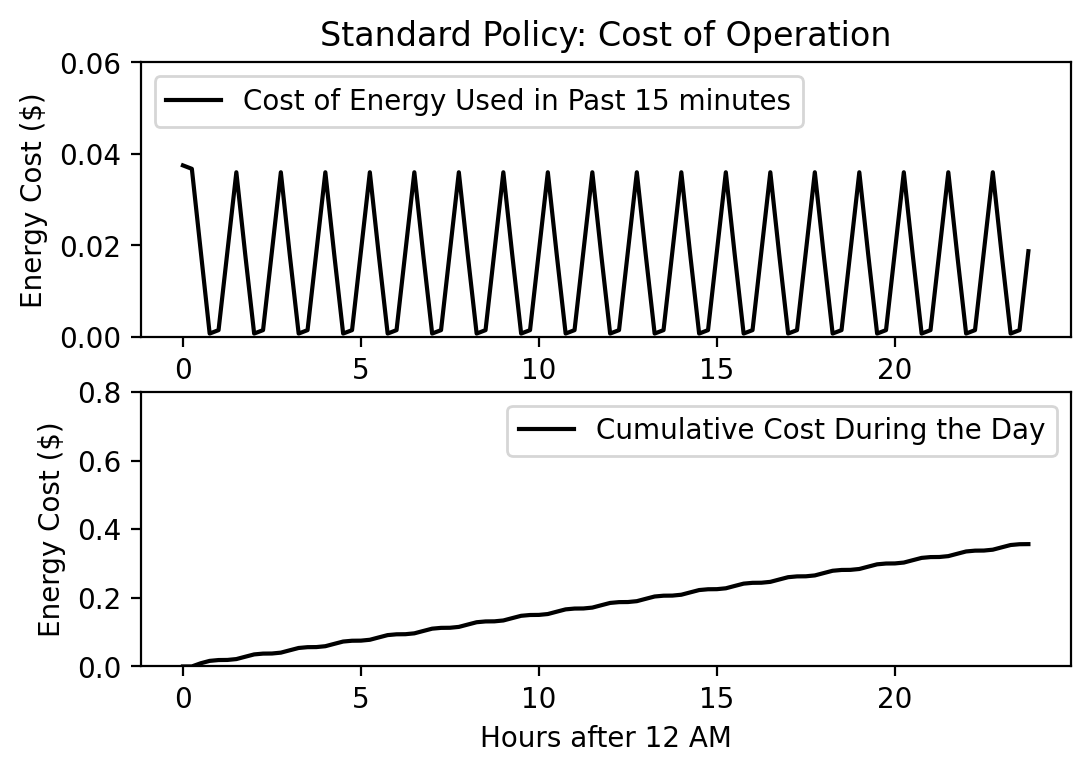

In [17]:
# Cumulative area under curve
cum_auc = [0]
x = time_list
y = np.mean(energy_usage*4*15/60 * 0.0375, axis=0)
for i in range(1, len(x)):
    cum_auc.append(np.trapz(y[0:i], x[0:i]))
plt.figure()
plt.subplot(211)
plt.title("Standard Policy: Cost of Operation")
plt.plot(time_list, np.mean(energy_usage*4*15/60 * 0.0375, axis=0), "black", label="Cost of Energy Used in Past 15 minutes")
plt.ylabel("Energy Cost ($)")
plt.legend(loc="upper left")
plt.ylim([0, 0.06])
plt.subplot(212)
plt.plot(time_list, cum_auc, "black", label="Cumulative Cost During the Day")
plt.legend()
plt.xlabel("Hours after 12 AM")
plt.ylabel("Energy Cost ($)")
plt.ylim([0, 0.8])
plt.savefig("standard_energy_plot.png")

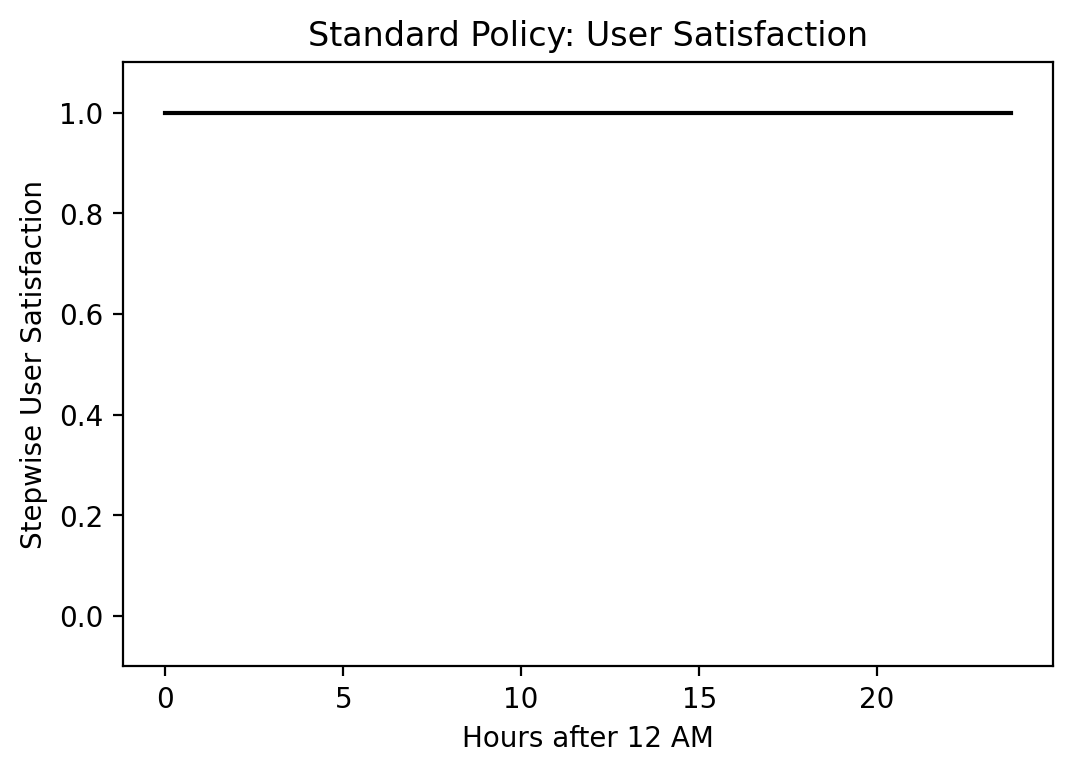

In [18]:
# Cumulative area under curve
cum_auc = [0]
x = time_list
y = np.mean(np.logical_not(reward < -100), axis=0)
for i in range(1, len(x)):
    cum_auc.append(np.trapz(y[0:i], x[0:i]))
plt.ylim([-0.1, 1.1])
plt.title("Standard Policy: User Satisfaction")
plt.plot(time_list, np.mean(np.logical_not(reward < -100), axis=0), "black", label="Stepwise Satisfaction")
plt.xlabel("Hours after 12 AM")
plt.ylabel("Stepwise User Satisfaction")
plt.savefig("standard_day_reward.png")

# Tankless Policy

In [19]:
def tankless_pred(time_spec):
    if time_spec.observation["usage_state"] > 0 and time_spec.observation["water_temperature"] < 160:
        return 1
    else:
        return 2

In [20]:
time_step_freq=1
states = np.array([0] * 6 * (60//time_step_freq) + [1] * 4 *
                               (60//time_step_freq) + [0] * 6 * (60//time_step_freq) + [1] * 4 * (60//time_step_freq) + [0] * 4 * (60//time_step_freq))

In [21]:
env = DailyUsageEnv(heating_power=8, time_step_freq=1, capacity=10)
env.reset()
total_iterations = 50
water_temp = np.zeros((total_iterations, 96*15,))
usage = np.zeros((total_iterations, 96*15,))
reward = np.zeros((total_iterations, 96*15,))
energy_usage = np.zeros((total_iterations, 96*15,))
actions = np.zeros((total_iterations, 96*15, ))
for k in tqdm(range(total_iterations)):
    spec = env.reset()
    for i in range(96*15):
        action = tankless_pred(spec)
        actions[k][i] = action
        spec = env.step(action)
        water_temp[k][i] = (spec.observation["water_temperature"])
        usage[k][i] = (spec.observation["usage_state"])
        energy_usage[k][i] = (spec.observation["boiler_state"])
        reward[k][i] = (spec.reward)
water_temp = (np.convolve(np.mean(water_temp, axis=0), np.ones(15), 'valid') / 15).reshape((1, 1426))
energy_usage = (np.convolve(np.mean(energy_usage, axis=0), np.ones(15), 'valid') / 15).reshape((1, 1426))
reward = (np.convolve(np.mean(reward, axis=0), np.ones(15), 'valid') / 15).reshape((1, 1426))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


In [22]:
time_list = []
for i in range(0, 23):
    for k in range(0, 60):
        time_list.append(i+k*1/60)
for i in range(46):
    time_list.append(23+i*1/46)

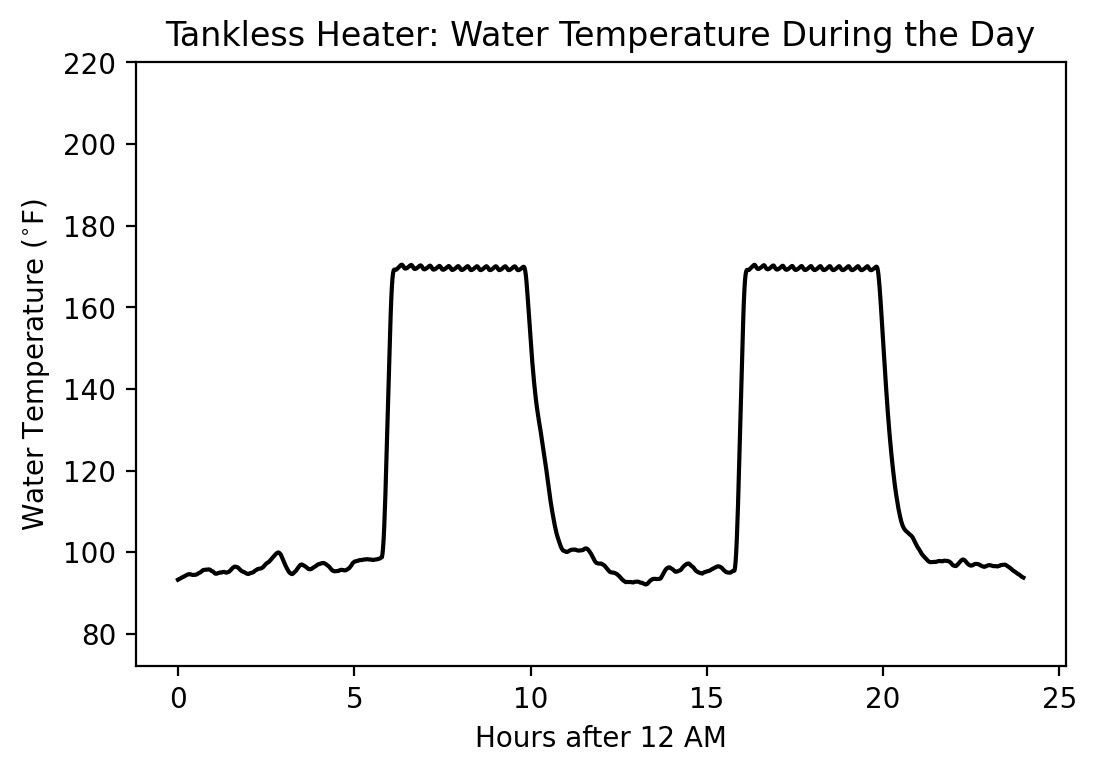

In [23]:
plt.figure()
plt.plot(time_list, np.mean(water_temp, axis=0), "black")
plt.xlabel("Hours after 12 AM")
plt.ylabel(r"Water Temperature ($^{\circ}$F)")
plt.ylim([72, 220])
plt.title("Tankless Heater: Water Temperature During the Day")
plt.savefig("tankless_water_temp.jpg")

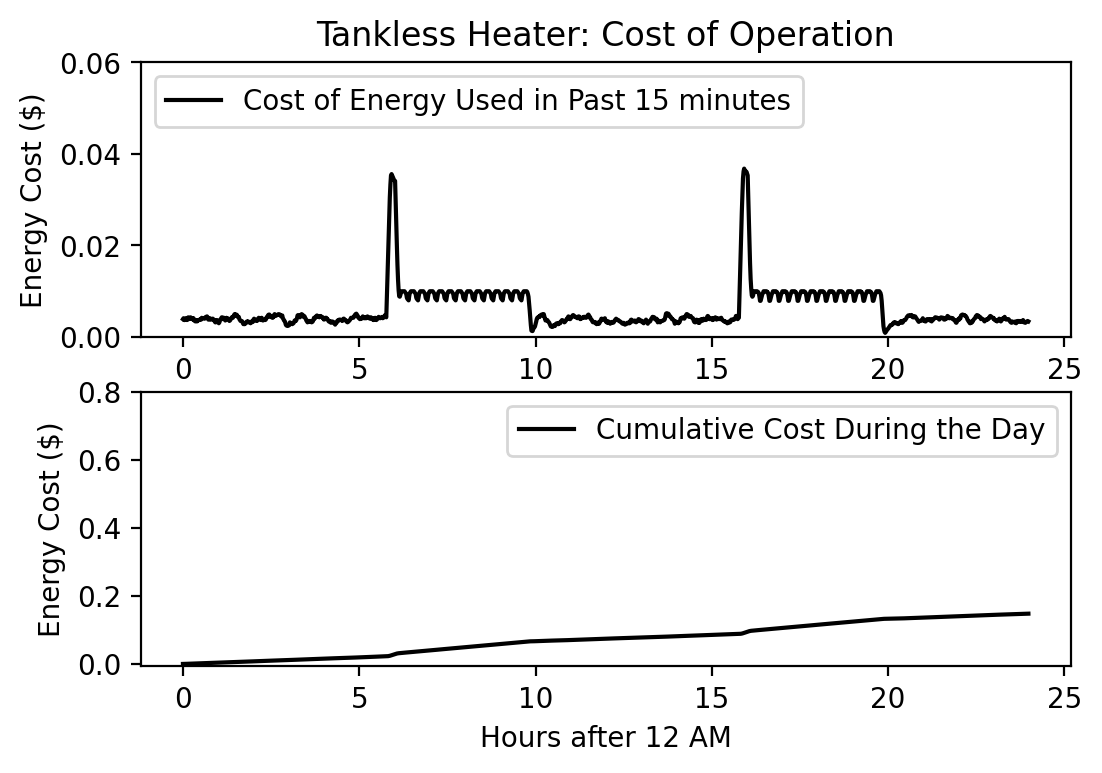

In [26]:
# Cumulative area under curve
cum_auc = [0]
x = time_list
y = np.mean(energy_usage*8*15/60 * 0.0375, axis=0)
for i in range(1, len(x)):
    cum_auc.append(np.trapz(y[0:i], x[0:i]))
plt.figure()
plt.subplot(211)
plt.title("Tankless Heater: Cost of Operation")
plt.plot(time_list, np.mean(energy_usage*8*15/60 * 0.0375, axis=0), "black", label="Cost of Energy Used in Past 15 minutes")
plt.ylabel("Energy Cost ($)")
plt.legend(loc="upper left")
plt.ylim([0, 0.06])
plt.subplot(212)
plt.plot(time_list, cum_auc, "black", label="Cumulative Cost During the Day")
plt.legend()
plt.xlabel("Hours after 12 AM")
plt.ylabel("Energy Cost ($)")
plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
plt.savefig("tankless_energy_plot.png")

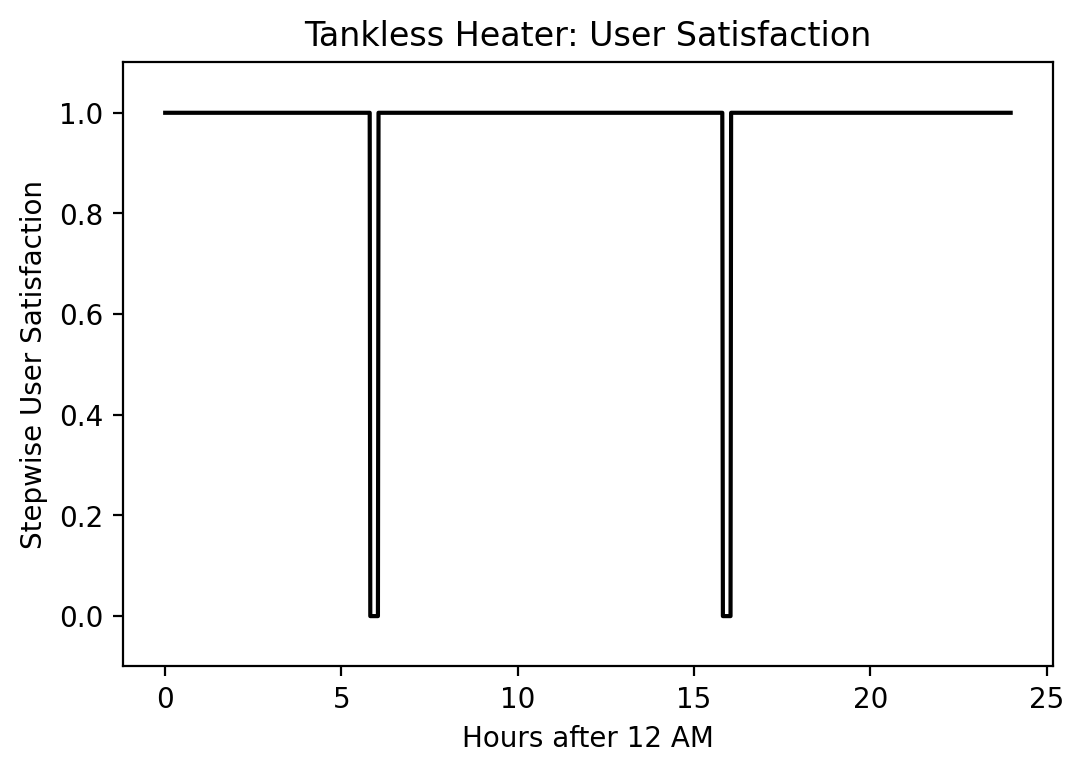

In [27]:
# Cumulative area under curve
cum_auc = [0]
x = time_list
y = np.mean(np.logical_not(reward < -100), axis=0)
for i in range(1, len(x)):
    cum_auc.append(np.trapz(y[0:i], x[0:i]))
plt.ylim([-0.1, 1.1])
plt.title("Tankless Heater: User Satisfaction")
plt.plot(time_list, np.mean(np.logical_not(reward < -100), axis=0), "black", label="Stepwise Satisfaction")
plt.xlabel("Hours after 12 AM")
plt.ylabel("Stepwise User Satisfaction")
plt.savefig("tankless_day_reward.png")